### EDA for Jane Street Competition

Here, I go through some simple exploratory data analysis on the features and target that they have given us. Let's see what we can find. Some quick notes: 
* We need to create a simple prediction function which will take our input and output some predicted value 
* We are meeasured based on some mean zero weighted r^2 metric --> going to need to write the evaluation function there. 
* We are predicting the "respondent_6" variable but we have 9 of these total

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys


In [3]:
training_data = pd.read_parquet("train_partition_0.parquet")

In [4]:
training_data.shape

(1944210, 92)

In [5]:
training_data.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000


In [6]:
# Get the features that have all NA values 
na_features = training_data.columns[training_data.isna().all()].tolist()

In [7]:
training_data = training_data.drop(na_features, axis=1)

In [8]:
def process_training_data(training_data: pd.DataFrame) -> pd.DataFrame: 
    na_features = training_data.columns[training_data.isna().all()].tolist()
    training_data = training_data.drop(na_features, axis=1)
    
    return training_data

In [9]:
features = training_data.filter(like='feature')
target = training_data.filter(like='responder')
prediction_target = target['responder_6']
weight = training_data['weight']
other_information = training_data.iloc[:, :3]

<Axes: title={'center': 'Weight Distribution'}, ylabel='Frequency'>

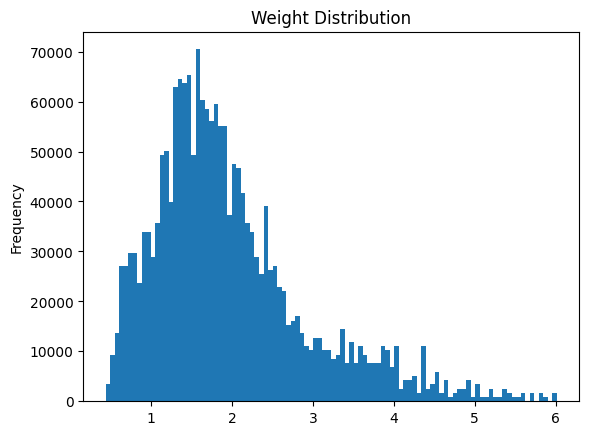

In [10]:
weight.plot(kind='hist', bins=100, title='Weight Distribution')

In [11]:
features.dtypes.value_counts()

float32    67
int8        2
int16       1
Name: count, dtype: int64

<Axes: title={'center': 'feature_28 Distribution'}, ylabel='Frequency'>

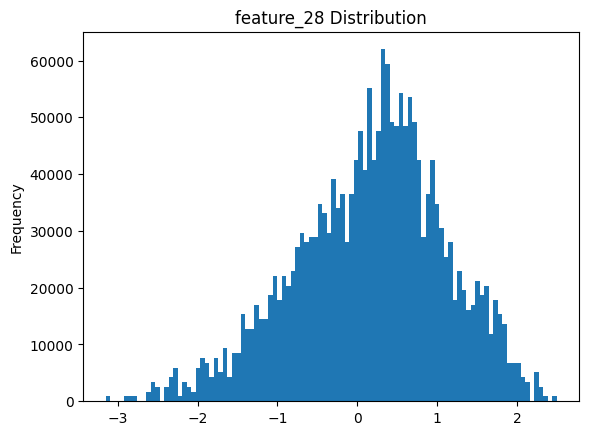

In [12]:
# Choose a random feature to plot
i = 20
feature = features.columns[i]
features[feature].plot(kind='hist', bins=100, title=f'{feature} Distribution')


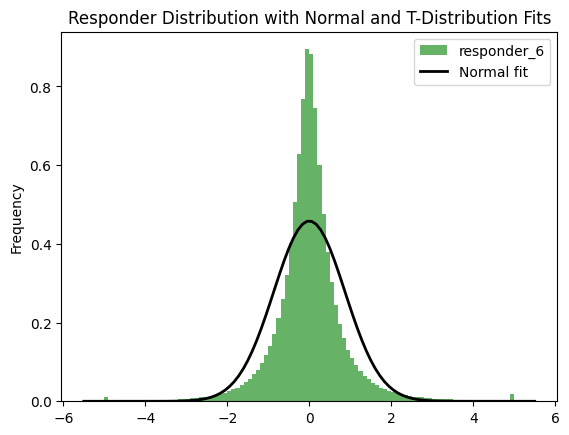

In [13]:
import scipy.stats as stats

# Fit a normal distribution to the data
mu, std = stats.norm.fit(target['responder_6'])

# Plot the histogram
ax = target['responder_6'].plot(kind='hist', bins=100, density=True, alpha=0.6, color='g', title='Responder Distribution with Normal and T-Distribution Fits')

# Plot the normal distribution density
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2, label='Normal fit')


ax.legend()
plt.show()

In [14]:
prediction_target.describe() 

count    1.944210e+06
mean     1.487634e-03
std      8.705768e-01
min     -5.000000e+00
25%     -3.558709e-01
50%     -9.597129e-03
75%      3.360999e-01
max      5.000000e+00
Name: responder_6, dtype: float64

In [15]:
# Find the correlations between the features and the prediction target 
correlations = features.corrwith(prediction_target)
correlations = correlations.sort_values(ascending=False)
abs_correlations = correlations.abs().sort_values(ascending=False)

In [16]:
abs_correlations.head(10)

feature_06    0.087681
feature_07    0.066128
feature_05    0.035586
feature_68    0.027078
feature_51    0.026465
feature_19    0.024511
feature_08    0.022325
feature_69    0.022006
feature_56    0.020750
feature_13    0.019468
dtype: float64

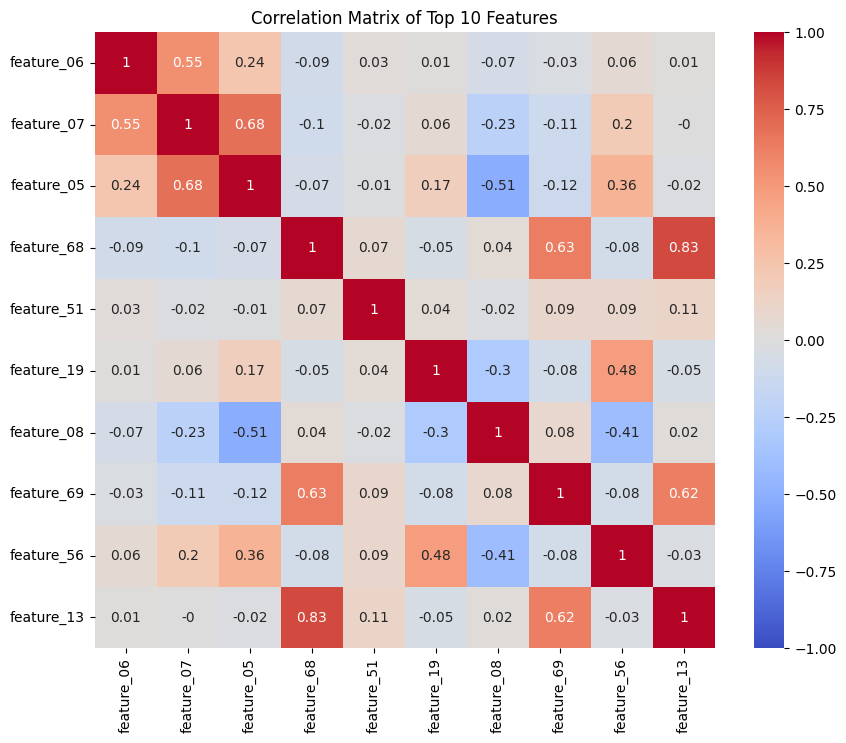

In [17]:
# Calculate the correlation matrix for the top 10 features
corr_matrix = features[abs_correlations.head(10).index].corr().round(2)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Top 10 Features')
plt.show()

In [18]:
top_10_features = features[abs_correlations.head(10).index.tolist()] 

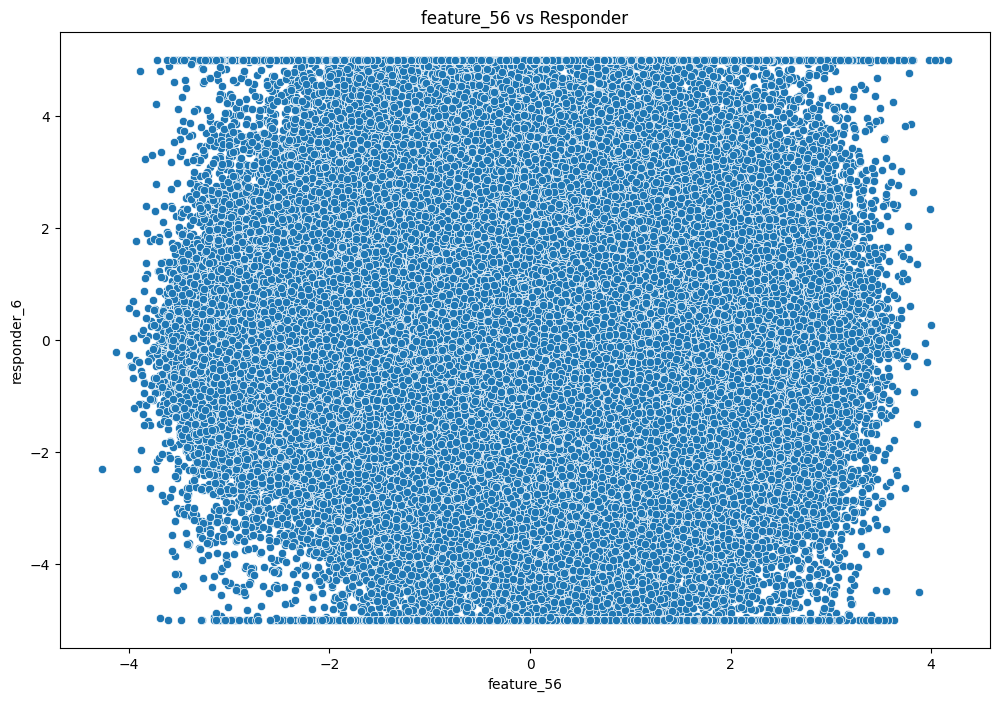

In [23]:
# Plot scatter plot of the top 10 features with the prediction target
idx = 8 
fig, ax = plt.subplots(figsize=(12, 8))
feature = top_10_features.columns[idx]
sns.scatterplot(data=training_data, x=feature, y='responder_6', ax=ax)
ax.set_title(f'{feature} vs Responder')
plt.show() 